In [11]:
import math
import random
import numpy as np
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm import tqdm

import json

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import torch
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_resnet50_fpn_v2

import os


In [2]:
def set_seed(seed_number:int=42, loader=None) -> None:
    '''
    Arguments:
    -----------
        - seed_number(int): Integer used to set seeds
    '''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed_number)
    
    np.random.seed(seed_number)
    
    random.seed(seed_number)
    
set_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
class CFG:
    
    train_batch_size = 4
    test_batch_size = 1
    
    lr = 0.0001
    lr_finetune = 0.0005
    weight_decay = 1e-4
    
    epochs = 300
    epochs_finetune = 15

cfg = CFG()

In [6]:
train_img_path = '/kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/train'
train_label_file = '/kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/train/_annotations.coco.json'
test_img_path = '/kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/test'
test_label_file = '/kaggle/input/vehicle-detection-image-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.coco/test/_annotations.coco.json'

In [7]:
with open(train_label_file) as json_file:
    train_data_dict = json.load(json_file)
    
with open(test_label_file) as json_file:
    test_data_dict = json.load(json_file)
train_data_dict['annotations'][0]

{'id': 0,
 'image_id': 0,
 'category_id': 3,
 'bbox': [310, 493, 22, 78],
 'area': 1716,
 'segmentation': [],
 'iscrowd': 0}

In [8]:
cat_mapping = dict() # Variable that maps class id -> class name
for category in train_data_dict['categories']:
    cat_mapping[category['id']] = category['name']

In [9]:
class Compose(object):
    def __init__(self, transforms):
        '''
        Arguments:
        -----------
            - transforms(list): list of augmentation classes objects
        Return:
        ---------
            None
        '''
        self.transforms = transforms

    def __call__(self, image, bboxes):
        '''
        Function that iterates data through all the augmentations in the augmentation list.
        Arguments:
        -----------
            - image(PIL.Image.Image): Image.
            - bboxes(torch.Tensor): Bounding boxes related to the image.
        Return:
        ---------
            - image(PIL.Image.Image): Image after all augmentations.
            - bboxes(torch.Tensor): Bounding boxes related to the image after all augmentations.
        '''
        for t in self.transforms:
            image, bboxes = t(image, bboxes)
        return image, bboxes

    
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        '''
        Arguments:
        -----------
            - p(float): probability of the augmentation being applied
        Return:
        ---------
            None
        '''
        self.p = p

    def __call__(self, image, bboxes):
        '''
        Function that applies the horizontal flip.
        Arguments:
        -----------
            - image(PIL.Image.Image): Image.
            - bboxes(torch.Tensor): Bounding boxes related to the image.
        Return:
        ---------
            - image(PIL.Image.Image): Image after horizontal flip.
            - bboxes(torch.Tensor): Bounding boxes related to the image after horizontal flip.
        '''
        if random.random() < self.p:
            image = F.hflip(image)
            width, _ = image.size
            if len(bboxes)!=0:
                bboxes = bboxes.clone()
                bboxes[:, [0, 2]] = width - bboxes[:, [2, 0]]  # Flip x_min and x_max
        return image, bboxes

    
class ToTensor(object):
    def __call__(self, image, bboxes):
        '''
        Function that transforms data into torch.Tensor type.
        Arguments:
        -----------
            - image(PIL.Image.Image): Image.
            - bboxes(torch.Tensor): Bounding boxes related to the image.
        Return:
        ---------
            - image(torch.Tensor): Image as a pytorch tensor.
            - bboxes(torch.Tensor): Bounding boxes that are not changed.
        '''
        image = F.to_tensor(image)
        return image, bboxes

In [15]:
img = np.array(img) / 255

NameError: name 'img' is not defined

In [13]:
train_transform = Compose([
            RandomHorizontalFlip(p=0.5),
            ToTensor()
        ])

val_transform = Compose([
            ToTensor()
        ])

test_transform = val_transform

In [14]:
class VehicleDetectionDataset(Dataset):
    def __init__(self, img_path, data_dict, transform=None):
        '''
        Arguments:
        -----------
            - images(np.ndarray): Array containing all images (X)
            - labels(np.ndarray): Array containing the targets (y)
            - lb(sklearn.preprocessing._label.LabelBinarizer): Label Binarizer to transform labels into one-hot vectors
            - transform(torchvision.transforms.transforms.Compose|None): Variable containing all transformations data has to go through
        Return:
        ---------
            None
        '''
        self.img_path = img_path
        self.data_dict = data_dict
        self.transform = transform
        self.dataset = self.create_dataset()
    
    def create_dataset(self):
        """
        Function to create dataset list, by pairing each image path to all the annotations in that image.
        Arguments:
        ---------
            None
        Return:
        ---------
            - dataset(list[list[str,dict]]): List containing the all the needed information related to the dataset.
        """
        dataset = []
        for element in self.data_dict["images"]:
            img_id = element['id']
            img_annotations = []
            for annotation in self.data_dict['annotations']:
                if annotation['image_id'] == img_id:
                    img_annotations.append(annotation)
            dataset.append([element['file_name'], img_annotations])
        
        return dataset
    
    def __len__(self):
        """
        Arguments:
        ---------
            None
        Return:
        ---------
            None
        """
        return len(self.data_dict['images'])
    
    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects,
        we need a collate function (to be passed to the DataLoader).
        
        Arguments:
        ---------
            - batch: an iterable of N sets from __getitem__()
        Return:
        ---------
            - images(torch.Tensor): a tensor of batch_size images
            - boxes(list[torch.Tensor]): list with batch_size varying-size tensors of bounding boxes
            - labels(list[torch.Tensor]): list with batch_size varying-size tensors of labels
            - areas(list[torch.Tensor]): list with batch_size varying-size tensors of areas
            - image_id(list[torch.Tensor]): list with batch_size varying-size tensors of image ids
        """
        images = list()
        boxes = list()
        labels = list()
        areas = list()
        image_id = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            areas.append(b[3])
            image_id.append(b[4])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, areas, image_id
    
    def __getitem__(self, idx):
        """
        Arguments:
        ---------
            - idx (int): Index for selecting a sample from the dataset
        Return:
        ---------
            - img(torch.Tensor): Single image.
            - bbs(torch.Tensor): Bounding boxes related to the image.
            - cat_ids(torch.Tensor): Labels corresponding to each bounding box in the image.
            - areas(torch.Tensor): Areas of each bounding box.
            - image_id(torch.Tensor): Image ID related to each bounding box. Since all bounding boxes are from the same image, image_id is a tensor with all equal values.
        """
        
        img = cv2.imread(os.path.join(self.img_path, self.dataset[idx][0]))
        #img = img.reshape().astype(np.uint8)
            
        cat_ids = []
        bbs = []
        areas = []
        iscrowd = []
        image_id = []
        for annotation in self.dataset[idx][1]:
            cat_ids.append(annotation['category_id'])
            bbs.append(annotation['bbox'])
            areas.append(annotation['area'])
            iscrowd.append(annotation['iscrowd'])
            image_id.append(annotation['image_id'])
        cat_ids = torch.Tensor(cat_ids)
        
        areas = torch.Tensor(areas)
        iscrowd = torch.Tensor(iscrowd)
        image_id = torch.Tensor(image_id)
        
        bbs = np.array(bbs)
        for i, bb in enumerate(bbs):
            x_min, y_min, width, height = bb
            x1, y1 = x_min, y_min
            x2, y2 = x_min + width, y_min + height
            bbs[i] = np.array([x1, y1, x2, y2])
        
        bbs = torch.Tensor(bbs)
        if self.transform:
            img = Image.fromarray(img)
            img, bbs = self.transform(img, bbs)
        
        bbs = torch.from_numpy(np.array(bbs))
        cat_ids = torch.Tensor(cat_ids).long()
        
        return img, bbs, cat_ids, areas, image_id

In [16]:
train_dataset = VehicleDetectionDataset(train_img_path, train_data_dict, transform=train_transform)
test_dataset = VehicleDetectionDataset(test_img_path, test_data_dict, transform=test_transform)
train_dataloader = DataLoader(train_dataset, batch_size=cfg.train_batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.test_batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)

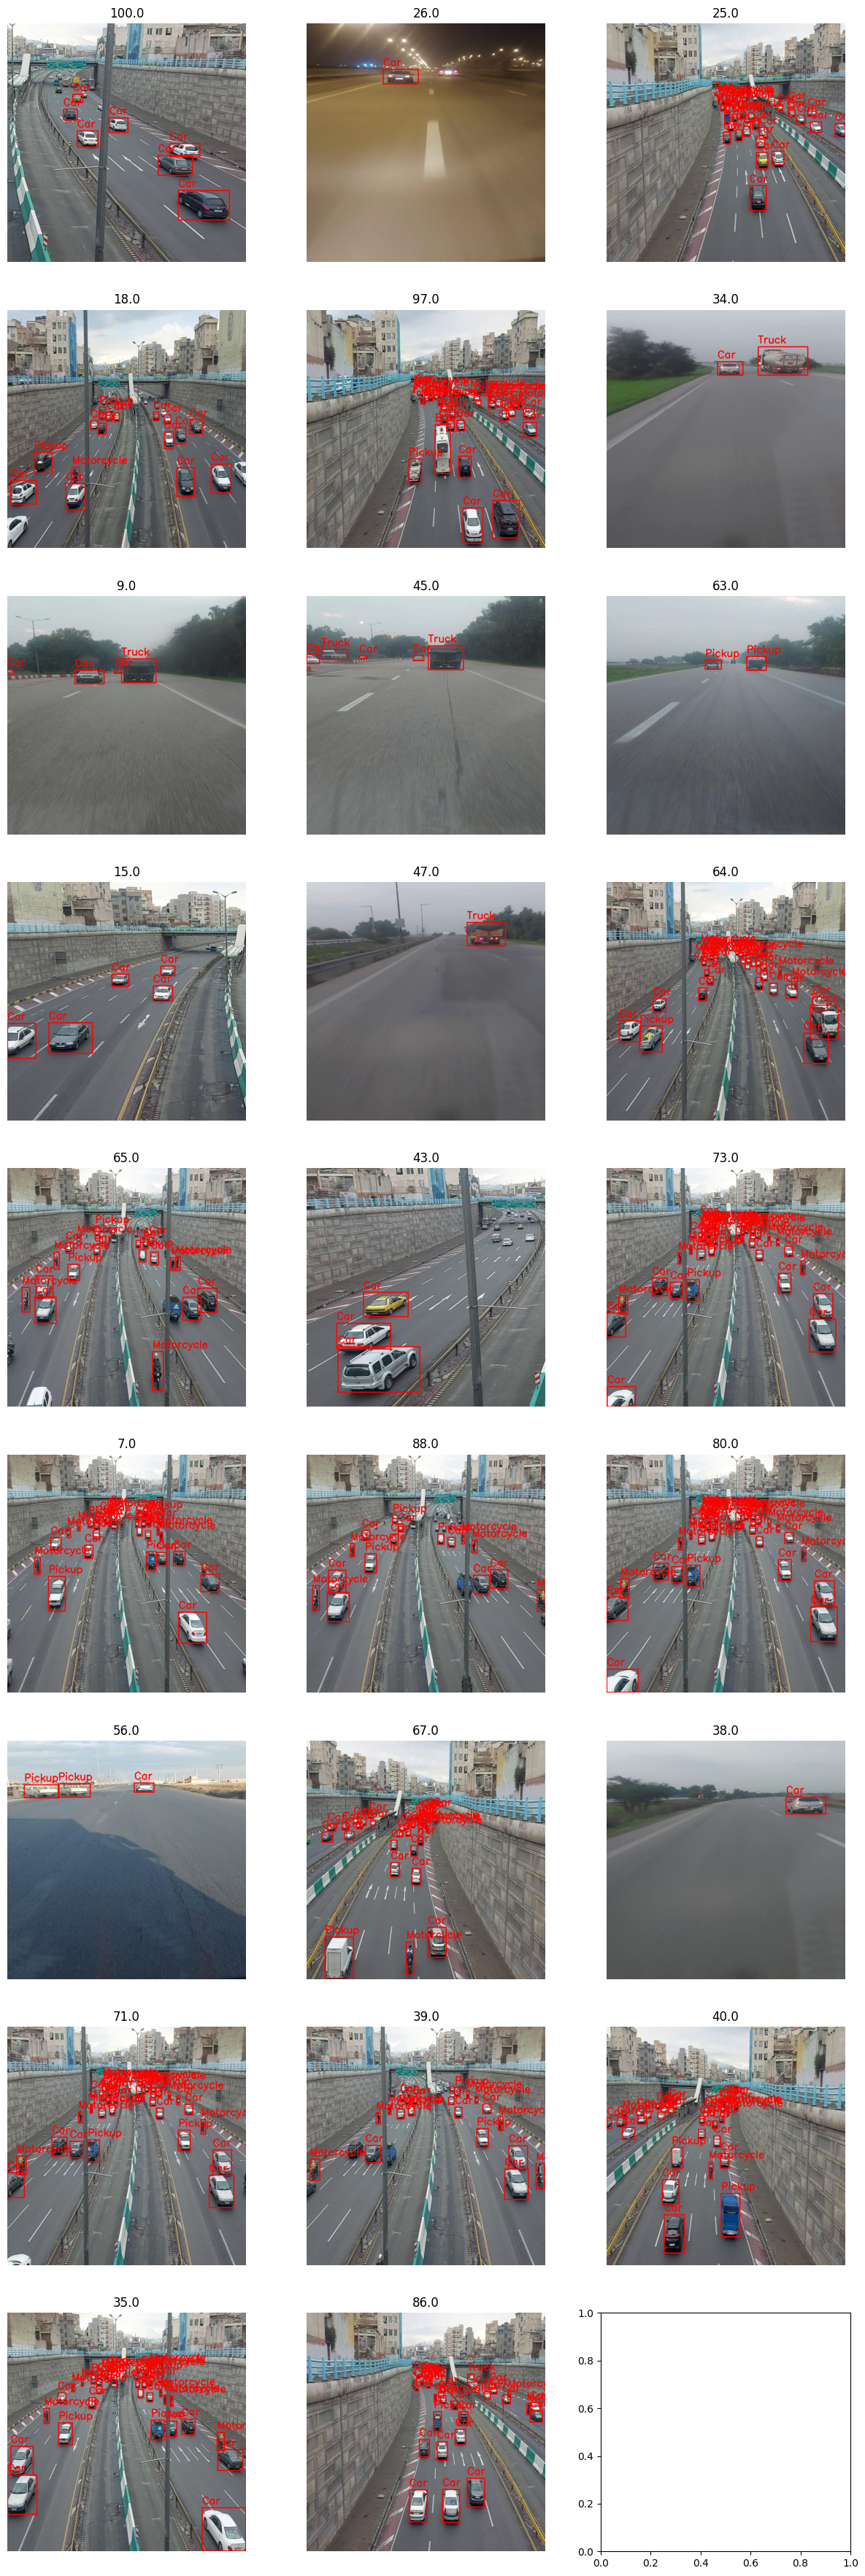

In [17]:
def plot_images_with_boxes(images, bbs, labels, image_id, class_names, ax, i, columns):
    """
    Plot some of the images with bounding boxes and class names.
    Arguments:
    ---------
        - images(torch.Tensor): Batch of images.
        - bbs(torch.Tensor): Batch of bounding boxes related to the images.
        - labels(torch.Tensor): Batch of labels corresponding to each bounding box.
        - image_id(torch.Tensor): Batch of image IDs related to each bounding box.
        - class_names(dict): Dict that maps each label to a class name.
        - ax(matplotlib.axes._axes.Axes): variable representing the axes in matplotlib subplots.
        - i(int): auxiliar variable for the plot. Indicates which row and column from ax to plot.
        - columns(int): Number of columns in the ax variable.
    Return:
    ---------
        None
    """
    for img, bb, lbl, img_id in zip(images, bbs, labels, image_id):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img * 255).astype(np.uint8) # Convert image from [0, 1] to [0, 255] range
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convert from RGB (Matplotlib) to BGR (OpenCV)       
        
        for box, label in zip(bb, lbl): # For each bounding box and label found in the image
            x1, y1, x2, y2 = map(int, box) # Convert Tensor values in box to integers
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)  # Draw bounding box
            cv2.putText(img, class_names[int(label)], org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=(255, 0, 0), thickness=2)  # Draw class label

        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert back to RGB for plotting
        ax[i//columns][i%columns].imshow(img)
        ax[i//columns][i%columns].axis("off")
        ax[i//columns][i%columns].set_title(f"{img_id[0]}")
        break

rows = math.ceil(len(train_dataloader)/3)
columns = 3
fig, ax = plt.subplots(rows, columns, figsize=(15, 45))
for i, (images, bbs, labels, areas, image_id) in enumerate(train_dataloader):
    plot_images_with_boxes(images, bbs, labels, image_id, cat_mapping, ax, i, columns)
plt.show()

In [18]:
class_frequencies = {cat_mapping[k]:0 for k,v in cat_mapping.items()}

for annotation in train_data_dict['annotations']:
    category_id = annotation['category_id']
    category_name = cat_mapping[category_id]
    class_frequencies[category_name] = class_frequencies[category_name] + 1
classes = list(class_frequencies.keys())
frequencies = list(class_frequencies.values())

fig = go.Figure(data=[go.Bar(x=classes, y=frequencies)])
fig.update_layout(
    title='Class Frequency Histogram',
    xaxis_title='Class Names',
    yaxis_title='Frequency',
    template='seaborn'
)

fig.show()

In [19]:
def get_model(num_classes, pretrained=False):
    """
    Create the model object.
    Arguments:
    ---------
        - num_classes(int): Number of classes.
        - pretrained(bool): Whether to use pretrained weights or not.
    Return:
    ---------
        - model(torch.nn.Module): Faster R-CNN model
    """
    
    model = fasterrcnn_resnet50_fpn(pretrained=pretrained)
    
    # Freezing backbone parameters
    if pretrained:
        for param in model.backbone.parameters():
            param.requires_grad = False
        
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace head to match my classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [20]:
def calculate_iou(box1, box2):
    """
    Function that calculates IoU metric.
    Arguments:
    ---------
        - box1(np.ndarray|list): First bounding box in the format (x_min, y_min, x_max, y_max).
        - box2(np.ndarray|list): Second bounding box in the format (x_min, y_min, x_max, y_max).
    Return:
    ---------
        - iou(float): Intersection over Union metric from the two bounding boxes.
    """
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_min_x = max(x1_min, x2_min)
    inter_min_y = max(y1_min, y2_min)
    inter_max_x = min(x1_max, x2_max)
    inter_max_y = min(y1_max, y2_max)

    inter_area = max(0, inter_max_x - inter_min_x) * max(0, inter_max_y - inter_min_y)

    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou
def plot_test_predictions(image, boxes, labels, scores, class_names, true_boxes, true_labels, image_id, iou_threshold=0.7):
    """
    Plot some of the test images with predicted bounding boxes and class names.
    Colors indicate if it was a right or wrong detection.
    
    Arguments:
    ---------
        - image(torch.Tensor): Batch of images.
        - boxes(torch.Tensor): Batch of predicted bounding boxes related to the images.
        - labels(torch.Tensor): Batch of predicted labels corresponding to each bounding box.
        - scores(torch.Tensor): Batch of predicted scores corresponding to each label.
        - class_names(dict): Dict that maps each label to a class name.
        - true_boxes(torch.Tensor): Batch of true (ground truth) bounding boxes related to the images.
        - true_labels(torch.Tensor): Batch of true (ground truth) labels corresponding to each bounding box.
        - image_id(torch.Tensor): Batch of image IDs related to each bounding box.
        - iou_threshold(float): Threshold used to verify if the predicted bounding box was in the right spot or not.
    Return:
    ---------
        None
    """
    image = image.permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8) # Convert back to [0, 255] range
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for box, label, score in zip(boxes, labels, scores): # For each bounding box and label found in the image
        x1, y1, x2, y2 = map(int, box)
        match = False
        match_bb = False
        for true_box, true_label in zip(true_boxes, true_labels):
            if calculate_iou(box, true_box) >= iou_threshold and label == true_label: # Bounding Box and class right
                match = True
            elif calculate_iou(box, true_box) >= iou_threshold: # Bounding Box right but class wrong
                match_bb = True
        
        text = f'{class_names[int(label)]}: {score:.2f}'
        if match:
            green = (0, 255, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=green, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=green, thickness=2)
        elif match_bb:
            blue = (0, 0, 255)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=blue, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=blue, thickness=2)
        else:
            red = (255, 0, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color=red, thickness=2)
            cv2.putText(image, text, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=red, thickness=2)

    plt.title(f'Image {int(image_id[0])}')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [21]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, epoch):
    """
    Plot some of the test images with predicted bounding boxes and class names.
    Colors indicate if it was a right or wrong detection.
    
    Arguments:
    ---------
        - model(torch.nn.Module): Model object.
        - dataloader(torch.utils.data.DataLoader): DataLoader used to load data in mini batches.
        - optimizer: Optimizer object used optimize the model weights.
        - lr_scheduler(torch.optim.lr_scheduler.StepLR): Scheduler to decrease learning rate every n epochs (where n is a hyperparameter).
        - epoch(int): Current epoch number.
    Return:
    ---------
        - average_train_loss(float): Average aggregated loss of the epoch.
        - average_classifier_loss(float): Average classification loss of the epoch.
        - average_box_reg_loss(float): Average box regression loss of the epoch.
    """
    model.train()
    
    i = 0
    total_train_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0
    total_samples = 0
    for images, bbs, labels, areas, image_id in dataloader:
        images = images.float().to(device)
        targets = [{'boxes':bbs[i].to(device), 'labels':labels[i].to(device)} for i, bb in enumerate(bbs)]

        optimizer.zero_grad()
        
        if 0 in list(map(len, bbs)):
            continue
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()
        
        total_train_loss += losses.item() * images.size(0)
        loss_classifier += loss_dict['loss_classifier'].item() * images.size(0)
        loss_box_reg += loss_dict['loss_box_reg'].item() * images.size(0)
        loss_objectness += loss_dict['loss_objectness'].item() * images.size(0)
        loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item() * images.size(0)
        total_samples += images.size(0)
        i += 1
        
    average_train_loss = total_train_loss / total_samples
    average_classifier_loss = loss_classifier / total_samples
    average_box_reg_loss = loss_box_reg / total_samples
    average_objectness_loss = loss_objectness / total_samples
    average_rpn_box_reg_loss = loss_rpn_box_reg / total_samples
    lr_scheduler.step()
    
    print(f"Epoch {epoch + 1}, Total Loss: {average_train_loss:.4f}, Class. Loss: {average_classifier_loss:.4f}, Box Reg. Loss: {average_box_reg_loss:.4f}, LR: {lr_scheduler.get_last_lr()[0]:.7f}", end='\r')
    
    return average_train_loss, average_classifier_loss, average_box_reg_loss

In [22]:
num_classes = len(cat_mapping.keys())  # Number of classes including background
pretrained_model = get_model(num_classes, pretrained=True).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:04<00:00, 35.7MB/s] 


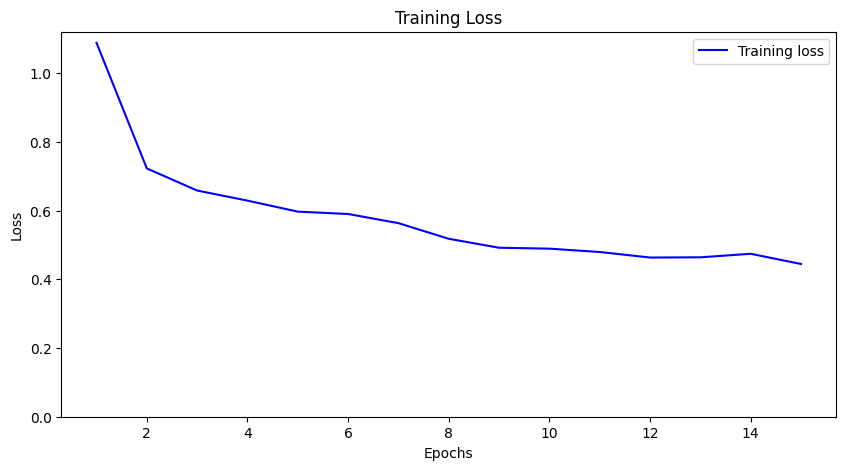

In [23]:
params = [p for p in pretrained_model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=cfg.lr_finetune, weight_decay=cfg.weight_decay)

#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.epochs_finetune//30, gamma=0.8)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.epochs_finetune//2, gamma=0.1)
pretrained_model.train()
# Training loop
train_losses = []
for epoch in range(cfg.epochs_finetune):
    epc_train_loss, epc_class_loss, epc_box_reg_loss = train_epoch(pretrained_model, train_dataloader, optimizer, lr_scheduler, epoch)
    train_losses.append(epc_train_loss)

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(bottom=0)
plt.show()

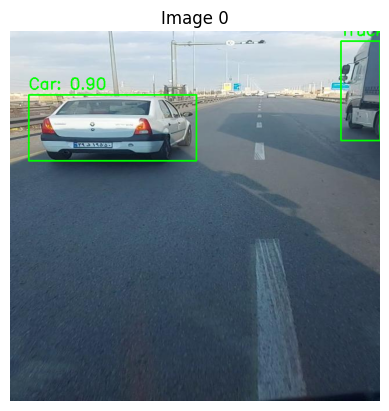

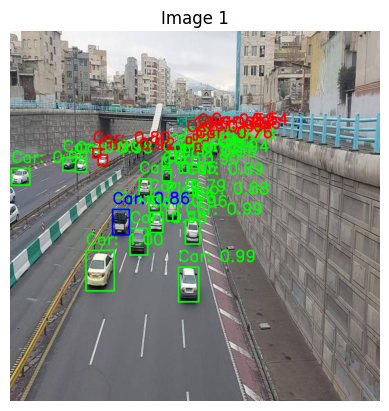

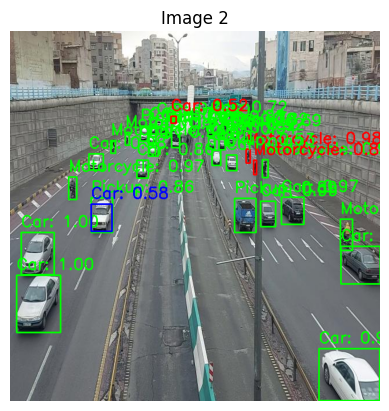

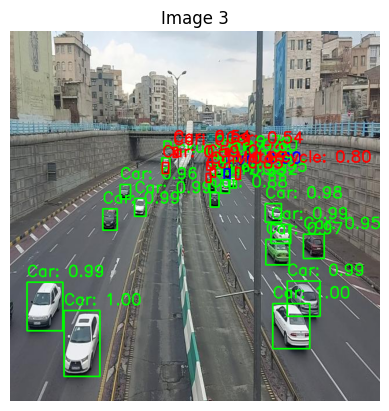

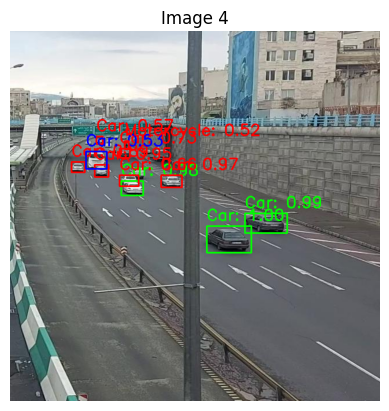

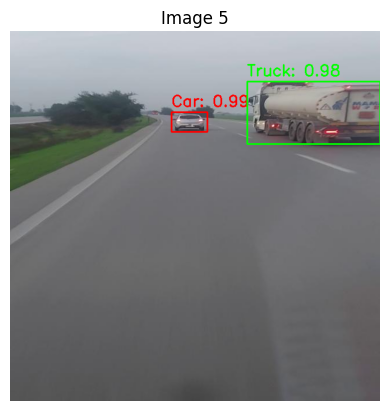

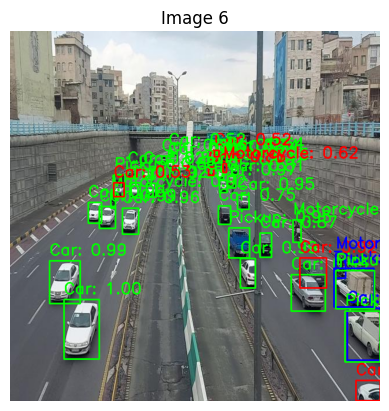

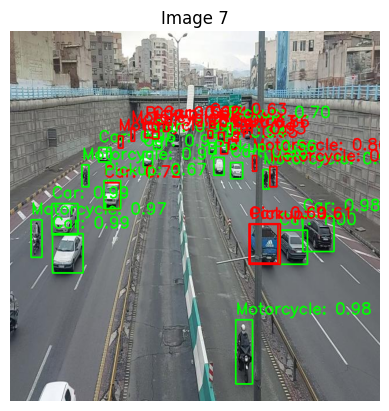

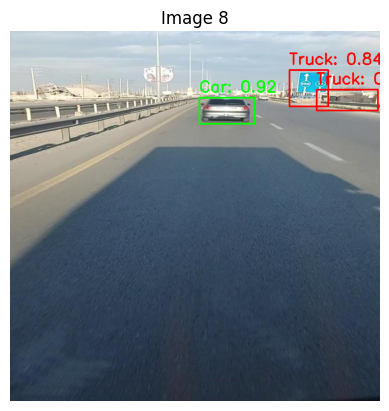

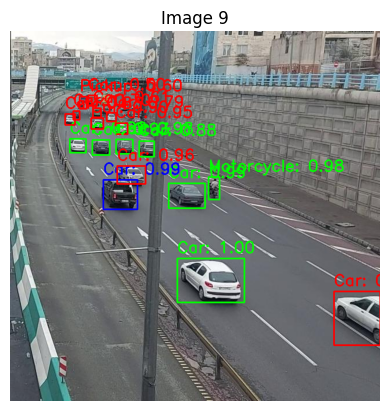

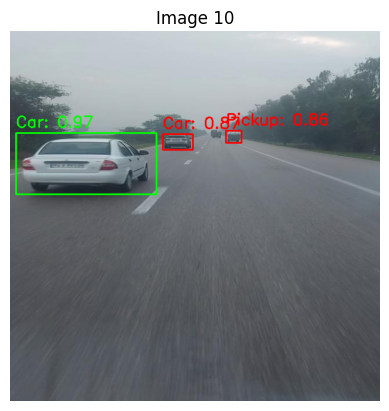

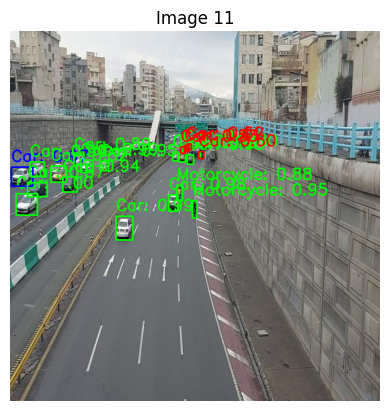

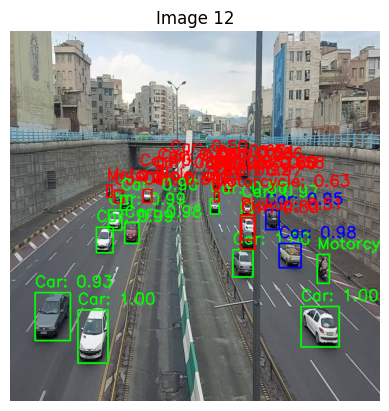

In [24]:
pretrained_model.eval()
for images, bbs, labels, areas, image_id in test_dataloader:
    images = images.float().to(device)

    with torch.no_grad():
        prediction = pretrained_model(images)
        
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    true_boxes = bbs[0].numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()
    true_labels = labels[0].numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_boxes = pred_boxes[pred_scores >= 0.5].tolist()
    pred_labels = pred_labels[pred_scores >= 0.5].tolist()
    pred_scores = pred_scores[pred_scores >= 0.5].tolist()

    images = images.cpu().detach()
    
    plot_test_predictions(images[0], pred_boxes, pred_labels, pred_scores, cat_mapping, true_boxes, true_labels, image_id[0])

In [31]:
import joblib

# Assuming 'model' is the trained model you want to save
joblib.dump(pretrained_model, 'pretrained_model.joblib')  # Save the model in the current working directory'path/to/save/pretrained_model.pth')

['pretrained_model.joblib']